In [27]:
import geopandas as gpd
from shapely.geometry import box

In [28]:
gdf = gpd.read_file("./resources/FAO_fishing_areas/FAO_AREAS_ERASE_LOWRES.json")
print(gdf.crs)

EPSG:4326


[-69.6095 -60.     -50.     -32.4483]


<Axes: >

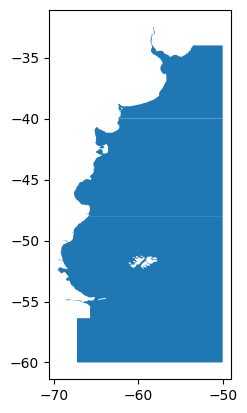

In [29]:
FAO_41 = gdf[gdf['F_AREA'] == '41']
FAO_41_Sub_32_31_23 = FAO_41[FAO_41['F_DIVISION'].isin(['41.3.2', '41.3.1', '41.2.3'])]
print(FAO_41_Sub_32_31_23.total_bounds)
FAO_41_Sub_32_31_23.plot()


EPSG:4326


<Axes: >

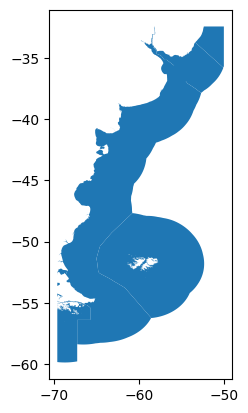

In [ ]:
min_lon, min_lat, max_lon, max_lat = FAO_41_Sub_32_31_23.total_bounds
bbox = (min_lon, min_lat, max_lon, max_lat)
eez = gpd.read_file("./resources/Marine_Regions/World_EEZ_v12/eez_v12.shp", bbox=bbox)
print(eez.crs)
bbox_geom = box(*bbox)
eez_clipped = gpd.clip(eez, bbox_geom)
eez_clipped.plot()
eez_clipped


In [ ]:
eez_falk = eez_clipped[eez_clipped['GEONAME'] == "Overlapping claim Falkland / Malvinas Islands: United Kingdom / Argentina"]
eez_no_falk = eez_clipped[eez_clipped['GEONAME'] != "Overlapping claim Falkland / Malvinas Islands: United Kingdom / Argentina"].copy()
fao_minus_eez = gpd.overlay(FAO_41_Sub_32_31_23, eez_no_falk, how='difference')
fao_minus_eez.plot()

In [43]:
land_polygons = gpd.read_file("./resources/OpenStreet_features/land-polygons-complete-4326/land_polygons.shp", bbox=bbox)
land_clipped = gpd.clip(land_polygons, bbox_geom)

In [ ]:
buffer_m = 12 * 1852
#TODO: hay que añadirle 12nm a la tierra para poder restarla luego a fao_minus_eez